# Darkeras: Execute YOLOv4 on Keras with Darknet Pre-trained Weights

## Import

In [1]:
import cv2
import numpy as np
import core_yolov4.utils as utils
import core_yolov4.common as common
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
import colorsys
import random

print(tf.__version__)
print(tf.keras.__version__)

2.3.0
2.4.0


In [2]:
def postprocess_boxes(pred_bbox, org_img_shape, input_size, score_threshold):

    valid_scale=[0, np.inf]
    pred_bbox = np.array(pred_bbox)

    pred_xywh = pred_bbox[:, 0:4]
    pred_conf = pred_bbox[:, 4]
    pred_prob = pred_bbox[:, 5:]

    # # (1) (x, y, w, h) --> (xmin, ymin, xmax, ymax)
    pred_coor = np.concatenate([pred_xywh[:, :2] - pred_xywh[:, 2:] * 0.5,
                                pred_xywh[:, :2] + pred_xywh[:, 2:] * 0.5], axis=-1)
    # # (2) (xmin, ymin, xmax, ymax) -> (xmin_org, ymin_org, xmax_org, ymax_org)
    org_h, org_w = org_img_shape

    resize_ratio_w, resize_ratio_h = input_size/org_w, input_size/org_h
    
    pred_coor[:, 0::2] = pred_coor[:, 0::2] / resize_ratio_w
    pred_coor[:, 1::2] = pred_coor[:, 1::2] / resize_ratio_h
    
    # # (3) clip some boxes those are out of range
    pred_coor = np.concatenate([np.maximum(pred_coor[:, :2], [0, 0]),
                                np.minimum(pred_coor[:, 2:], [org_w - 1, org_h - 1])], axis=-1)
    invalid_mask = np.logical_or((pred_coor[:, 0] > pred_coor[:, 2]), (pred_coor[:, 1] > pred_coor[:, 3]))
    pred_coor[invalid_mask] = 0

    # # (4) discard some invalid boxes
    bboxes_scale = np.sqrt(np.multiply.reduce(pred_coor[:, 2:4] - pred_coor[:, 0:2], axis=-1))
    scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

    # # (5) discard some boxes with low scores
    classes = np.argmax(pred_prob, axis=-1)
    scores = pred_conf * pred_prob[np.arange(len(pred_coor)), classes]
    score_mask = scores > score_threshold
    mask = np.logical_and(scale_mask, score_mask)
    coors, scores, classes = pred_coor[mask], scores[mask], classes[mask]

    return np.concatenate([coors, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)

def bboxes_iou(boxes1, boxes2):

    boxes1 = np.array(boxes1)
    boxes2 = np.array(boxes2)

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    left_up       = np.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down    = np.minimum(boxes1[..., 2:], boxes2[..., 2:])

    inter_section = np.maximum(right_down - left_up, 0.0)
    inter_area    = inter_section[..., 0] * inter_section[..., 1]
    union_area    = boxes1_area + boxes2_area - inter_area
    ious          = np.maximum(1.0 * inter_area / union_area, np.finfo(np.float32).eps)

    return ious


def nms(bboxes, iou_threshold, sigma=0.3, method='nms'):

    classes_in_img = list(set(bboxes[:, 5]))
    best_bboxes = []

    for cls in classes_in_img:
        cls_mask = (bboxes[:, 5] == cls)
        cls_bboxes = bboxes[cls_mask]

        while len(cls_bboxes) > 0:
            max_ind = np.argmax(cls_bboxes[:, 4])
            best_bbox = cls_bboxes[max_ind]
            best_bboxes.append(best_bbox)
            cls_bboxes = np.concatenate([cls_bboxes[: max_ind], cls_bboxes[max_ind + 1:]])
            iou = bboxes_iou(best_bbox[np.newaxis, :4], cls_bboxes[:, :4])
            weight = np.ones((len(iou),), dtype=np.float32)

            assert method in ['nms', 'soft-nms']

            if method == 'nms':
                iou_mask = iou > iou_threshold
                weight[iou_mask] = 0.0

            if method == 'soft-nms':
                weight = np.exp(-(1.0 * iou ** 2 / sigma))

            cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
            score_mask = cls_bboxes[:, 4] > 0.
            cls_bboxes = cls_bboxes[score_mask]

    return best_bboxes

In [3]:
def cspdarknet53(input_data):

    input_data = common.convolutional(input_data, (3, 3,  3,  32), activate_type="mish")
    input_data = common.convolutional(input_data, (3, 3, 32,  64), downsample=True, activate_type="mish")

    route = input_data
    route = common.convolutional(route, (1, 1, 64, 64), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 64, 64), activate_type="mish")
    for i in range(1):
        input_data = common.residual_block(input_data,  64,  32, 64, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 64, 64), activate_type="mish")

    input_data = tf.concat([input_data, route], axis=-1)
    input_data = common.convolutional(input_data, (1, 1, 128, 64), activate_type="mish")
    input_data = common.convolutional(input_data, (3, 3, 64, 128), downsample=True, activate_type="mish")
    route = input_data
    route = common.convolutional(route, (1, 1, 128, 64), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 128, 64), activate_type="mish")
    for i in range(2):
        input_data = common.residual_block(input_data, 64,  64, 64, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 64, 64), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 128, 128), activate_type="mish")
    input_data = common.convolutional(input_data, (3, 3, 128, 256), downsample=True, activate_type="mish")
    route = input_data
    route = common.convolutional(route, (1, 1, 256, 128), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 256, 128), activate_type="mish")
    for i in range(8):
        input_data = common.residual_block(input_data, 128, 128, 128, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 128, 128), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 256, 256), activate_type="mish")
    route_1 = input_data
    input_data = common.convolutional(input_data, (3, 3, 256, 512), downsample=True, activate_type="mish")
    route = input_data
    route = common.convolutional(route, (1, 1, 512, 256), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 512, 256), activate_type="mish")
    for i in range(8):
        input_data = common.residual_block(input_data, 256, 256, 256, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 256, 256), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 512, 512), activate_type="mish")
    route_2 = input_data
    input_data = common.convolutional(input_data, (3, 3, 512, 1024), downsample=True, activate_type="mish")
    route = input_data
    route = common.convolutional(route, (1, 1, 1024, 512), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 1024, 512), activate_type="mish")
    for i in range(4):
        input_data = common.residual_block(input_data, 512, 512, 512, activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 512, 512), activate_type="mish")
    input_data = tf.concat([input_data, route], axis=-1)

    input_data = common.convolutional(input_data, (1, 1, 1024, 1024), activate_type="mish")
    input_data = common.convolutional(input_data, (1, 1, 1024, 512))
    input_data = common.convolutional(input_data, (3, 3, 512, 1024))
    input_data = common.convolutional(input_data, (1, 1, 1024, 512))

    input_data = tf.concat([tf.nn.max_pool(input_data, ksize=13, padding='SAME', strides=1), tf.nn.max_pool(input_data, ksize=9, padding='SAME', strides=1)
                            , tf.nn.max_pool(input_data, ksize=5, padding='SAME', strides=1), input_data], axis=-1)
    input_data = common.convolutional(input_data, (1, 1, 2048, 512))
    input_data = common.convolutional(input_data, (3, 3, 512, 1024))
    input_data = common.convolutional(input_data, (1, 1, 1024, 512))

    return route_1, route_2, input_data

In [4]:
def YOLOv4(input_layer):
    NUM_CLASS = 80
    
    route_1, route_2, conv = cspdarknet53(input_layer)

    route = conv
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.upsample(conv)
    route_2 = common.convolutional(route_2, (1, 1, 512, 256))
    conv = tf.concat([route_2, conv], axis=-1)

    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.upsample(conv)
    route_1 = common.convolutional(route_1, (1, 1, 256, 128))
    conv = tf.concat([route_1, conv], axis=-1)

    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv = common.convolutional(conv, (1, 1, 256, 128))

    route_1 = conv
    conv = common.convolutional(conv, (3, 3, 128, 256))
    conv_sbbox = common.convolutional(conv, (1, 1, 256, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(route_1, (3, 3, 128, 256), downsample=True)
    conv = tf.concat([conv, route_2], axis=-1)

    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv = common.convolutional(conv, (1, 1, 512, 256))

    route_2 = conv
    conv = common.convolutional(conv, (3, 3, 256, 512))
    conv_mbbox = common.convolutional(conv, (1, 1, 512, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    conv = common.convolutional(route_2, (3, 3, 256, 512), downsample=True)
    conv = tf.concat([conv, route], axis=-1)

    conv = common.convolutional(conv, (1, 1, 1024, 512))
    conv = common.convolutional(conv, (3, 3, 512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024, 512))
    conv = common.convolutional(conv, (3, 3, 512, 1024))
    conv = common.convolutional(conv, (1, 1, 1024, 512))

    conv = common.convolutional(conv, (3, 3, 512, 1024))
    conv_lbbox = common.convolutional(conv, (1, 1, 1024, 3 * (NUM_CLASS + 5)), activate=False, bn=False)

    return [conv_sbbox, conv_mbbox, conv_lbbox]

In [5]:
def decode(conv_output, i=0):
    
    NUM_CLASS = 80
    STRIDES = np.array([8, 16, 32])
    
    anchors = np.array([12, 16, 19, 36, 40, 28, 36, 75, 76, 55, 72, 146, 142, 110, 192, 243, 459, 401])
    
    ANCHORS = anchors.reshape(3, 3, 2)
    
    XYSCALE=[1.05, 1.05, 1.05]
    
    conv_shape = tf.shape(conv_output)
    batch_size = conv_shape[0]
    output_size = conv_shape[1]
    
    conv_output = tf.reshape(conv_output,
                             (batch_size, output_size, output_size, 3, 5 + NUM_CLASS))

    conv_raw_dxdy, conv_raw_dwdh, conv_raw_conf, conv_raw_prob = tf.split(conv_output, (2, 2, 1, NUM_CLASS), axis=-1)

    xy_grid = tf.meshgrid(tf.range(output_size), tf.range(output_size))
    xy_grid = tf.expand_dims(tf.stack(xy_grid, axis=-1), axis=2)  # [gx, gy, 1, 2]
    xy_grid = tf.tile(tf.expand_dims(xy_grid, axis=0), [batch_size, 1, 1, 3, 1])

    xy_grid = tf.cast(xy_grid, tf.float32)

    pred_xy = ((tf.sigmoid(conv_raw_dxdy) * XYSCALE[i]) - 0.5 * (XYSCALE[i] - 1) + xy_grid) * STRIDES[i]
    pred_wh = (tf.exp(conv_raw_dwdh) * ANCHORS[i])
    pred_xywh = tf.concat([pred_xy, pred_wh], axis=-1)

    pred_conf = tf.sigmoid(conv_raw_conf)
    pred_prob = tf.sigmoid(conv_raw_prob)

    return tf.concat([pred_xywh, pred_conf, pred_prob], axis=-1)

## Create Model - Load Weights

In [6]:
input_size   = 608
input_layer  = tf.keras.layers.Input([input_size, input_size, 3])
feature_maps = YOLOv4(input_layer)

feature_maps_array = np.array(feature_maps)

for fmap in feature_maps_array:
    print(fmap.shape)

(None, 76, 76, 255)
(None, 38, 38, 255)
(None, 19, 19, 255)


In [7]:
bbox_tensors = []
for i, fm in enumerate(feature_maps):
    bbox_tensor = decode(fm, i)
    bbox_tensors.append(bbox_tensor)

In [44]:
# Load Weights
model = tf.keras.Model(input_layer, bbox_tensors)
utils.load_weights(model, "./weights/yolov4.weights")
# model.summary()

In [9]:
# If you want to save weights as h5 format
# model.save_weights("yolov4_waymo.h5")

## Load Image - Predict

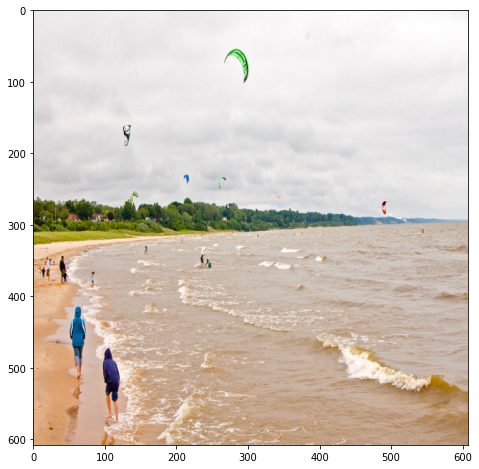

In [37]:
image_path = "./docs/kite.jpg"
original_image      = cv2.imread(image_path)
original_image      = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)
original_image_size = original_image.shape[:2]

image_data = cv2.resize(original_image, (input_size, input_size))
image_data = image_data/255.
image_data = image_data[np.newaxis, ...].astype(np.float32)

image_data_display = cv2.resize(original_image, (input_size,input_size))

plt.figure(figsize=(8,8))
plt.imshow(image_data_display)
plt.show()

In [38]:
pred_bbox = model.predict(image_data)
pred_bbox = [tf.reshape(x, (-1, tf.shape(x)[-1])) for x in pred_bbox]
pred_bbox = tf.concat(pred_bbox, axis=0)

In [39]:
pred_bbox_array = np.array(pred_bbox)
bboxes = postprocess_boxes(pred_bbox, original_image_size, input_size, 0.05)
bboxes = nms(bboxes, 0.45, method='nms')

(900, 1352, 3)


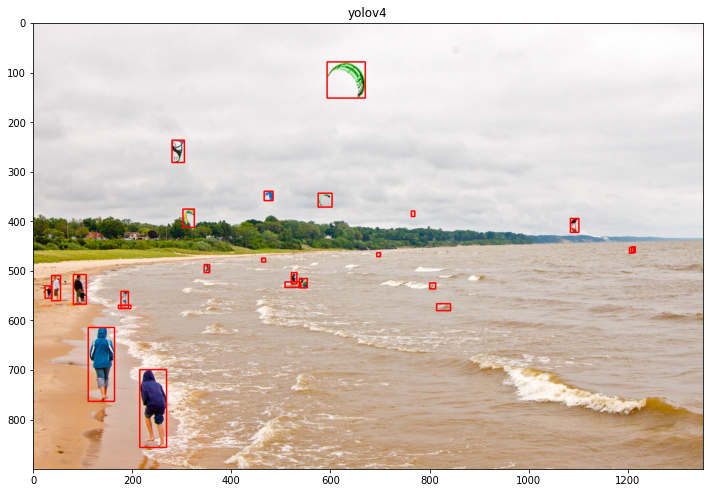

In [41]:
dummy = np.copy(original_image)
print(dummy.shape)

for box in bboxes:
    
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    conf = box[4]
    cls_id = int(box[5])
        
    dummy = cv2.rectangle(dummy, (x1,y1), (x2,y2), (255,0,0), 2)
     
plt.figure(figsize=(12,10))
plt.gca().set_title("yolov4"), plt.imshow(dummy)
plt.show()

## Draw Boxes

In [32]:
def read_class_names(class_file_name):
    names = {}
    with open(class_file_name, 'r') as data:
        for ID, name in enumerate(data):
            names[ID] = name.strip('\n')
    return names

In [33]:
def draw_bbox(image, bboxes, show_label=True):
    """
    bboxes: [x_min, y_min, x_max, y_max, probability, cls_id] format coordinates.
    """
    
    classes = read_class_names("./data/classes/coco.names")

    num_classes = len(classes)
    image_h, image_w, _ = image.shape
    hsv_tuples = [(1.0 * x / num_classes, 1., 1.) for x in range(num_classes)]
    colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
    colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), colors))

    random.seed(0)
    random.shuffle(colors)
    random.seed(None)

    for i, bbox in enumerate(bboxes):
        coor = np.array(bbox[:4], dtype=np.int32)
        fontScale = 0.5
        score = bbox[4]
        class_ind = int(bbox[5])
        bbox_color = colors[class_ind]
        bbox_thick = int(0.6 * (image_h + image_w) / 600)
        c1, c2 = (coor[0], coor[1]), (coor[2], coor[3])
        cv2.rectangle(image, c1, c2, bbox_color, bbox_thick)

        if show_label:
            bbox_mess = '%s: %.2f' % (classes[class_ind], score)
            t_size = cv2.getTextSize(bbox_mess, 0, fontScale, thickness=bbox_thick//2)[0]
            cv2.rectangle(image, c1, (c1[0] + t_size[0], c1[1] - t_size[1] - 3), bbox_color, -1)  # filled

            cv2.putText(image, bbox_mess, (c1[0], c1[1]-2), cv2.FONT_HERSHEY_SIMPLEX,
                        fontScale, (0, 0, 0), bbox_thick//2, lineType=cv2.LINE_AA)

    return image

In [34]:
image = draw_bbox(original_image, bboxes)

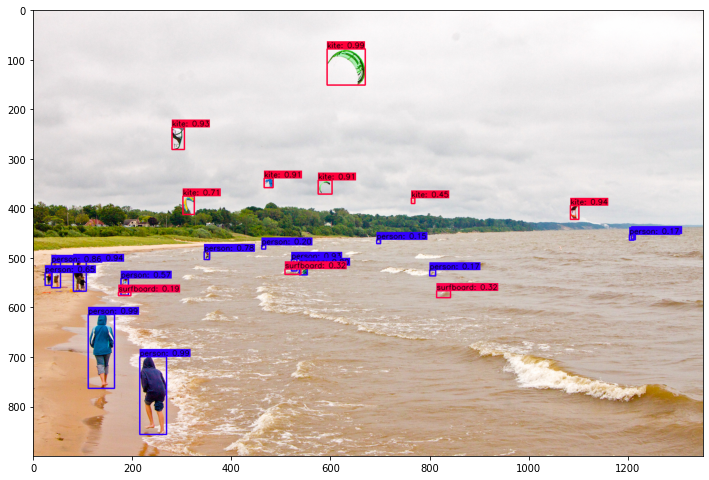

In [35]:
plt.figure(figsize=(12,10))
plt.imshow(image)
plt.show()

In [43]:
cv2.imwrite("detections.jpg", cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

True